In [23]:
%pip install lightgbm
%pip install pandas
%pip install scikit-learn
%pip install tqdm
%pip install requests

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\erika\.pyenv\pyenv-win\versions\3.9.0\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\erika\.pyenv\pyenv-win\versions\3.9.0\python.exe -m pip install --upgrade pip' command.


^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\erika\.pyenv\pyenv-win\versions\3.9.0\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\Users\erika\.pyenv\pyenv-win\versions\3.9.0\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\erika\.pyenv\pyenv-win\versions\3.9.0\python.exe -m pip install --upgrade pip' command.


In [ ]:
import requests

# Here instead of hostname you can also use the ip adresse Displayed in NordVPN
url = 'http://l.kremp-everest.nord:5000/query'

N = 10  # Change this to the number of documents you need

# Update the SQL query to fetch the first N documents
query = f'SELECT * FROM documents LIMIT {N}'

# Basic authentication details
auth = ('mseproject', 'tuebingen2024')

# Make the POST request to the Flask API with your query
response = requests.post(url, json={'query': query}, auth=auth)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    if data:
        #here i can access the result via the index "count" because i renamed it ^
        count = data
        print(f"Total documents count: {count}")
    else:
        print("No data returned.")
else:
    print(f"Error executing query: {response.status_code} - {response.text}")

Total documents count: [{'url': 'https://www.tuebingen.de/en/', 'title': 'Welcome to Tübingen - City of Tuebingen', 'content': "Welcome to Tübingen - City of Tuebingen Immigration office European Elections 2024 Portrait of the City City and Guests Culture and Leisure Bild: Universitätsstadt Tübingen Show search input Hide search input City Map Deutsch Welcome to Tübingen June 27th, 2024 Small steps, narrow alleys and pointed gables shape the silhouette of old Tübingen on the way up\xa0to its castle. The Swabian university town of about 91,000 inhabitants and 28,000 students combines the flair of a lovingly restored medieval centre\xa0with the colorful bustle and typical atmosphere of a young and cosmopolitan students' town. Numerous sidewalk cafes, wine taverns and cozy students' pubs, special shops, restaurants and taverns invite visitors to stroll around and to pause here and there. Taking a boat trip in a famous “Stocherkahn“ – the boat exclusive to Tübingen navigated by a long wood

In [ ]:
count

[{'url': 'https://www.tuebingen.de/en/',
  'title': 'Welcome to Tübingen - City of Tuebingen',
  'content': "Welcome to Tübingen - City of Tuebingen Immigration office European Elections 2024 Portrait of the City City and Guests Culture and Leisure Bild: Universitätsstadt Tübingen Show search input Hide search input City Map Deutsch Welcome to Tübingen June 27th, 2024 Small steps, narrow alleys and pointed gables shape the silhouette of old Tübingen on the way up\xa0to its castle. The Swabian university town of about 91,000 inhabitants and 28,000 students combines the flair of a lovingly restored medieval centre\xa0with the colorful bustle and typical atmosphere of a young and cosmopolitan students' town. Numerous sidewalk cafes, wine taverns and cozy students' pubs, special shops, restaurants and taverns invite visitors to stroll around and to pause here and there. Taking a boat trip in a famous “Stocherkahn“ – the boat exclusive to Tübingen navigated by a long wooden pole – offers a 

In [1]:
import numpy as np
from collections import Counter
from typing import List, Dict
import pandas as pd

class PrecomputedDocumentFeatures:
    
    def __init__(self, documents: List[dict]):
        self.documents = documents
        self.doc_count = len(documents)
        self.idf_cache = {}
        self.precomputed_features = []
        self._build_idf_cache()
        self._precompute_features()
    
    def _build_idf_cache(self): 
        """ 
        Pre-compute IDF for all terms in the corpus. 
        WARNING: IDF defined as: 1 divided by the number of documents containing the query terms.
        """
        term_doc_count = Counter()
        for doc in self.documents:
            content = doc['content']
            url = doc['url']
            outgoing_links = doc['outgoing_links']
            whole_document = f"{content} {url} {outgoing_links}".lower() # lower!
            unique_terms = set(whole_document.split())
            for term in unique_terms:
                term_doc_count[term] += 1
        
        for term, count in term_doc_count.items():
            self.idf_cache[term] = 1 / (count + 1)
    
    def compute_idf(self, term: str) -> float:
        """ Compute IDF for a given term using the pre-computed IDF cache. """
        return self.idf_cache.get(term, 1 / (1 + 1))  # Default IDF for unseen terms
    
    def stream_length(self, text: str) -> int:
        """ Determine the length of the text in terms of word count. """
        return len(text.split())
    
    def term_frequencies(self, text: str) -> Dict[str, int]:
        """ Compute term frequencies for a given text. """
        return Counter(text.split())
    
    def _trim_content(self, content: str) -> str:
        """ Trim 20% off the beginning and end of the content as body. """
        words = content.split()
        total_length = len(words)
        cut_off = int(total_length * 0.2)
        trimmed_words = words[cut_off: total_length - cut_off]
        return ' '.join(trimmed_words)
    
    def _precompute_features(self):
        """ Pre-compute features for all documents. """
        for doc in self.documents:
            content = doc['content'].lower()
            body = self._trim_content(content)
            title = doc['title'].lower()
            url = doc['url'].lower()
            outgoing_links = doc['outgoing_links'].lower()
            url_splitted = url.replace('/', ' ').replace('.', ' ').split()
            url_terms = ' '.join(url_splitted)
            outgoing_links_terms = ' '.join(outgoing_links.replace('/', ' ').replace('.', ' ').split())
            whole_document = f"{content} {url_terms} {outgoing_links_terms}"
            
            body_term_freq = self.term_frequencies(body)
            title_term_freq = self.term_frequencies(title)
            url_term_freq = self.term_frequencies(url_terms)
            whole_doc_term_freq = self.term_frequencies(whole_document)
            
            body_features = {
                'stream_length': self.stream_length(body),
                'term_freq': body_term_freq
            }
            
            title_features = {
                'stream_length': self.stream_length(title),
                'term_freq': title_term_freq
            }
            
            url_features = {
                'stream_length': len(url_splitted[2]), # only the main part of the url e.g. tuebingen from https://www.tuebingen.de
                'term_freq': url_term_freq
            }
            
            whole_doc_features = {
                'stream_length': self.stream_length(whole_document),
                'term_freq': whole_doc_term_freq
            }
            
            self.precomputed_features.append({
                'content': body_features,
                'title': title_features,
                'url': url_features,
                'whole_document': whole_doc_features
            })
    
    
    
    def extract_query_features(self, query: str, order=False) -> pd.DataFrame:
        """ Extract query-specific features using pre-computed document features. """
        query_terms = query.lower().split()
        all_features = []
        
        part_order = {'content': 1, 'title': 3, 'url': 4, 'whole_document': 5}

        for doc_features in self.precomputed_features:
            features = {}
            for part in ['content', 'title', 'url', 'whole_document']:
                term_freq = doc_features[part]['term_freq']
                # Use the precomputed IDF values for the query terms
                idf_values = [self.compute_idf(term) for term in query_terms]
                
                query_term_freqs = [term_freq[term] for term in query_terms if term in term_freq]
                tf_idf_values = [term_freq[term] * idf for term, idf in zip(query_terms, idf_values) if term in term_freq]
                
                covered_query_terms = len(query_term_freqs)
                sum_term_freq = sum(query_term_freqs)
                min_term_freq = min(query_term_freqs, default=0)
                max_term_freq = max(query_term_freqs, default=0)
                mean_term_freq = round(sum(query_term_freqs) / len(query_term_freqs), 6) if query_term_freqs else 0.000000
                var_term_freq = round(sum((x - mean_term_freq) ** 2 for x in query_term_freqs) / len(query_term_freqs), 6) if query_term_freqs else 0.000000
                
                sum_tf_idf = round(sum(tf_idf_values), 6) if tf_idf_values else 0.000000
                min_tf_idf = round(min(tf_idf_values), 6) if tf_idf_values else 0.000000
                max_tf_idf = round(max(tf_idf_values), 6) if tf_idf_values else 0.000000
                mean_tf_idf = round(sum(tf_idf_values) / len(tf_idf_values), 6) if tf_idf_values else 0.000000
                var_tf_idf = round(sum((x - mean_tf_idf) ** 2 for x in tf_idf_values) / len(tf_idf_values), 6) if tf_idf_values else 0.000000
                
                # IDF feature for the query terms
                idf = round(sum(idf_values) / len(idf_values), 6) if idf_values else 0.000000
                
                feature_values = [
                    covered_query_terms,
                    covered_query_terms / len(query_terms),
                    doc_features[part]['stream_length'],
                    idf,
                    sum_term_freq,
                    min_term_freq,
                    max_term_freq,
                    mean_term_freq,
                    var_term_freq,
                    sum_tf_idf,
                    min_tf_idf,
                    max_tf_idf,
                    mean_tf_idf,
                    var_tf_idf
                ]
                
                # Microsoft Dataset feature names
                feature_names = [
                    part_order[part],
                    part_order[part] + 5,
                    part_order[part] + 10,
                    part_order[part] + 15,
                    part_order[part] + 20,
                    part_order[part] + 25,
                    part_order[part] + 30,
                    part_order[part] + 35,
                    part_order[part] + 40,
                    part_order[part] + 70,
                    part_order[part] + 75,
                    part_order[part] + 80,
                    part_order[part] + 85,
                    part_order[part] + 90
                ]
                for name, value in zip(feature_names, feature_values):
                    features[name] = value
            all_features.append(features)

        df_results = pd.DataFrame(all_features)

        if order:
            df_results = df_results.reindex(sorted(df_results.columns, key=int), axis=1)
        
        return df_results
# Example usage
documents = [
    {
        'url': 'https://www.tuebingen.de/en/1815.html',
        'title': 'Portrait of the City - City of Tuebingen',
        'content': "Portrait of the City - City of Tuebingen Immigration office European Elections 2024 Portrait of the City Places of Interest History Districts Sister cities Personalities University Picture Galleries City and Guests Culture and Leisure Bild: Stuttgart Regio Show search input Hide search input City Map Deutsch Welcome to Tübingen Portrait of the City Portrait tuebingen of the City The Swabian university town of 90,000 inhabitants and 28,000 students combines the flair of a lovingly restored medieval centre of town with the colorful bustle and typical atmosphere of a young and cosmopolitan students' town. Tübingen – the small big city Could you tell us in just one minute what makes Tübingen so unique? The new corporate video exactly faces up to this challenge. A strategic alliance consisting of the business development, supporting companies, city council and the agency Bär Tiger Wolf realized the video project. Beim Abspielen des Videos werden Daten an YouTube übertragen. Weitere Hinweise finden Sie in unserer Datenschutzerklärung . Proceed here Places of Interest History Districts Sister cities Personalities University Picture Galleries Webcam Market Place Privacy Policy Imprint Top",
        'outgoing_links': 'https://www.tuebingen.de/en/1815.html,https://www.tuebingen.de/en/3328.html,https://www.tuebingen.de/datenschutz,https://www.tuebingen.de/en/3332.html,https://www.tuebingen.de/en/3327.html,https://www.tuebingen.de/stadtplan,https://www.tuebingen.de/en/3515.html,https://www.tuebingen.de/en/3331.html,https://www.tuebingen.de/en/42067.html,https://www.tuebingen.de/en/3330.html,https://www.tuebingen.de/en/3329.html,https://www.tuebingen.de/,https://www.tuebingen.de/en/3494.html,https://www.tuebingen.de/en/1821.html,https://www.tuebingen.de/en/3514.html,https://www.tuebingen.de/en,https://www.tuebingen.de/en/23132.html,https://www.tuebingen.de/en/42070.html',
        'timestamp': '2024-06-21:56:30.478153',
        'pagerank': 0.007226454716830875
    },
    {
        'url': 'https://www.tuebingen.de/en/1815.html',
        'title': 'Portrait of the City - City of Tuebingen',
        'content': "Portrait of the City - City of Tuebingen Immigration office European Elections 2024 Portrait of the City Places of Interest History Districts Sister cities Personalities University Picture Galleries City and Guests Culture and Leisure Bild: Stuttgart Regio Show search input Hide search input City Map Deutsch Welcome to Tübingen Portrait of the City Portrait tuebingen of the City The Swabian university town of 90,000 inhabitants and 28,000 students combines the flair of a lovingly restored medieval centre of town with the colorful bustle and typical atmosphere of a young and cosmopolitan students' town. Tübingen – the small big city Could you tell us in just one minute what makes Tübingen so unique? The new corporate video exactly faces up to this challenge. A strategic alliance consisting of the business development, supporting companies, city council and the agency Bär Tiger Wolf realized the video project. Beim Abspielen des Videos werden Daten an YouTube übertragen. Weitere Hinweise finden Sie in unserer Datenschutzerklärung . Proceed here Places of Interest History Districts Sister cities Personalities University Picture Galleries Webcam Market Place Privacy Policy Imprint Top",
        'outgoing_links': 'https://www.tuebingen.de/en/1815.html,https://www.tuebingen.de/en/3328.html,https://www.tuebingen.de/datenschutz,https://www.tuebingen.de/en/3332.html,https://www.tuebingen.de/en/3327.html,https://www.tuebingen.de/stadtplan,https://www.tuebingen.de/en/3515.html,https://www.tuebingen.de/en/3331.html,https://www.tuebingen.de/en/42067.html,https://www.tuebingen.de/en/3330.html,https://www.tuebingen.de/en/3329.html,https://www.tuebingen.de/,https://www.tuebingen.de/en/3494.html,https://www.tuebingen.de/en/1821.html,https://www.tuebingen.de/en/3514.html,https://www.tuebingen.de/en,https://www.tuebingen.de/en/23132.html,https://www.tuebingen.de/en/42070.html',
        'timestamp': '2024-06-21:56:30.478153',
        'pagerank': 0.007226454716830875
    }
    # Add more documents as needed
]

query = "first tuebingen"

feature_extractor = PrecomputedDocumentFeatures(documents) # assume the documents are not lowercased, not NLP perf for now

query_features = feature_extractor.extract_query_features(query, order=True)
query_features


,1,3,4,5,6,8,9,10,11,13,...,84,85,86,88,89,90,91,93,94,95
0,1,1,1,1,0.5,0.5,0.5,0.5,109,8,...,0.333333,7.0,0.333333,0.333333,0.333333,7.0,0.0,0.0,0.0,0.0
1,1,1,1,1,0.5,0.5,0.5,0.5,109,8,...,0.333333,7.0,0.333333,0.333333,0.333333,7.0,0.0,0.0,0.0,0.0


In [87]:
query_features[66]

0    0.0
Name: 66, dtype: float64

In [24]:

import pandas as pd
import numpy as np

def get_data(data_path, top_k = None):
    if top_k:
        dfs = {
            "train": pd.read_csv(f"{data_path}/train.txt", delimiter=" ", header=None).head(top_k),
            "vali": pd.read_csv(f"{data_path}/vali.txt", delimiter=" ", header=None).head(top_k),
            "test": pd.read_csv(f"{data_path}/test.txt", delimiter=" ", header=None).head(top_k),
        }
    else:
        dfs = {
            "train": pd.read_csv(f"{data_path}/train.txt", delimiter=" ", header=None),
            "vali": pd.read_csv(f"{data_path}/vali.txt", delimiter=" ", header=None),
            "test": pd.read_csv(f"{data_path}/test.txt", delimiter=" ", header=None),
        }


    for df in dfs.values():
        df.columns = np.arange(len(df.columns))
        df.drop(columns=df.columns[df.isna().all()].tolist(), inplace=True)  # delete columns where all data is missing

    split = {}
    split["X_train"] = dfs["train"].iloc[:, 1:]
    split["X_val"] = dfs["vali"].iloc[:, 1:]
    split["X_test"] = dfs["test"].iloc[:, 1:]

    y_train = dfs["train"].iloc[:, 0]
    y_val = dfs["vali"].iloc[:, 0]
    y_test = dfs["test"].iloc[:, 0]

    # Create group parameters for LightGBM
    group_train = dfs["train"].groupby(1).size().to_list()
    group_vali = dfs["vali"].groupby(1).size().to_list()
    group_test = dfs["test"].groupby(1).size().to_list()

    # Specify the columns to keep
    columns_to_keep = [1, 4, 5, 6, 9, 10, 11, 14, 15, 16, 19, 20, 21, 24, 25, 26, 29, 30, 31, 34, 35, 36, 39, 40, 41, 44, 45, 71, 74, 75, 76, 79, 80, 81, 84, 85, 86, 89, 90, 91, 94, 95, 106, 109, 110, 126, 127, 129] 
    # add 130
    # add ti

    for name, df in split.items():
        df = df.applymap(lambda x: x.split(":", 1)[-1])  # Get rid of irrelevant information
        df = df.astype(float)  # Convert data into float format
        df = df.drop(columns=1)  # Drop the query ID column
        df.columns = [i for i in range(1, 137)]  # Rename column indices
        df = df[columns_to_keep]  # Keep only specified columns
        split[name] = df

    return (
        split["X_train"],
        split["X_test"],
        split["X_val"],
        y_train,
        y_test,
        y_val,
        group_train,
        group_vali,
        group_test
    )

In [25]:
# Load data
data_path = "training_data/Fold1"
X_train, X_test, X_val, y_train, y_test, y_val, group_train, group_vali, group_test = get_data(data_path)

C:\Users\erika\AppData\Local\Temp\ipykernel_30080\2480318331.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.split(":", 1)[-1])  # Get rid of irrelevant information
C:\Users\erika\AppData\Local\Temp\ipykernel_30080\2480318331.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.split(":", 1)[-1])  # Get rid of irrelevant information
C:\Users\erika\AppData\Local\Temp\ipykernel_30080\2480318331.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.split(":", 1)[-1])  # Get rid of irrelevant information


In [50]:
X_val[14]

0         10.0
1         11.0
2         11.0
3          8.0
4          5.0
          ... 
235254     9.0
235255    11.0
235256    12.0
235257     9.0
235258     9.0
Name: 14, Length: 235259, dtype: float64

In [51]:
X_val[127]

0         45.0
1         76.0
2         73.0
3         54.0
4         36.0
          ... 
235254    36.0
235255    58.0
235256    61.0
235257    42.0
235258    36.0
Name: 127, Length: 235259, dtype: float64

In [104]:
from multiprocessing import cpu_count
import lightgbm as lgb
import tqdm
cpu_count = cpu_count()
print(cpu_count)
total_boost_round = 1000

# Train the LightGBM model
lgb_ranker = lgb.LGBMRanker(
    objective='lambdarank',
    boosting_type='dart', # enhancement of gradient boosting decision tree
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=total_boost_round,  # Maximum number of boosting rounds; epochs
    n_jobs=cpu_count
    
)

lgb_ranker.fit(
    X_train, y_train,
    group=group_train,
    eval_set=[(X_test, y_test)],
    eval_group=[group_test],
    eval_at=[10],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50), # early stopping not available with dart,
        lgb.log_evaluation(period=1, show_stdv=True),  # Log evaluation results
    ]
)

20
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8926
[LightGBM] [Info] Number of data points in the train set: 723412, number of used features: 48
[1]	valid_0's ndcg@10: 0.32939
[2]	valid_0's ndcg@10: 0.354588
[3]	valid_0's ndcg@10: 0.36559


c:\Users\erika\.pyenv\pyenv-win\versions\3.9.0\lib\site-packages\lightgbm\callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[4]	valid_0's ndcg@10: 0.371243
[5]	valid_0's ndcg@10: 0.374331
[6]	valid_0's ndcg@10: 0.375234
[7]	valid_0's ndcg@10: 0.380259
[8]	valid_0's ndcg@10: 0.380771
[9]	valid_0's ndcg@10: 0.381503
[10]	valid_0's ndcg@10: 0.382654
[11]	valid_0's ndcg@10: 0.386328
[12]	valid_0's ndcg@10: 0.385614
[13]	valid_0's ndcg@10: 0.387128
[14]	valid_0's ndcg@10: 0.388463
[15]	valid_0's ndcg@10: 0.3888
[16]	valid_0's ndcg@10: 0.389785
[17]	valid_0's ndcg@10: 0.390234
[18]	valid_0's ndcg@10: 0.391138
[19]	valid_0's ndcg@10: 0.392645
[20]	valid_0's ndcg@10: 0.392216
[21]	valid_0's ndcg@10: 0.392939
[22]	valid_0's ndcg@10: 0.393621
[23]	valid_0's ndcg@10: 0.393284
[24]	valid_0's ndcg@10: 0.393899
[25]	valid_0's ndcg@10: 0.394014
[26]	valid_0's ndcg@10: 0.395067
[27]	valid_0's ndcg@10: 0.395799
[28]	valid_0's ndcg@10: 0.396006
[29]	valid_0's ndcg@10: 0.397242
[30]	valid_0's ndcg@10: 0.397828
[31]	valid_0's ndcg@10: 0.398383
[32]	valid_0's ndcg@10: 0.397846
[33]	valid_0's ndcg@10: 0.39862
[34]	valid_0's ndcg

KeyboardInterrupt: 

In [ ]:
# Predict relevance scores for the test set
y_pred = lgb_ranker.predict(X_val, pred_contrib=True)

In [ ]:
import pandas as pd
# Convert SHAP values to a DataFrame for easier interpretation
shap_df = pd.read_csv("shap.csv")

# Print the first few rows of the SHAP values DataFrame
print(shap_df.head())

   Unnamed: 0         1         4         5         6         9        10  \
0           0 -0.054033  0.000107 -0.006830  0.100243 -0.013155  0.008991   
1           1  0.022449  0.004343 -0.000502  0.112198  0.071568  0.011986   
2           2 -0.015280 -0.000075 -0.003388 -0.032585 -0.004236  0.004560   
3           3 -0.042986 -0.000001 -0.004402 -0.109738 -0.013113  0.006975   
4           4 -0.012143 -0.000033  0.004788 -0.034025 -0.003830  0.004854   

         11        14        15  ...        91        94        95       106  \
0 -0.172520 -0.076436 -0.126598  ...  0.007750 -0.001333 -0.008869  0.015197   
1  0.454581 -0.053024  0.168211  ...  0.001042  0.013087  0.036831  0.016810   
2 -0.032725 -0.098763 -0.014974  ... -0.002238 -0.002435  0.012904 -0.011863   
3 -0.070174 -0.092451 -0.022752  ... -0.003590 -0.001406  0.023206 -0.003629   
4  0.175237 -0.014907  0.222876  ... -0.000446 -0.004227  0.022978 -0.017126   

        109       110       126       127       129     

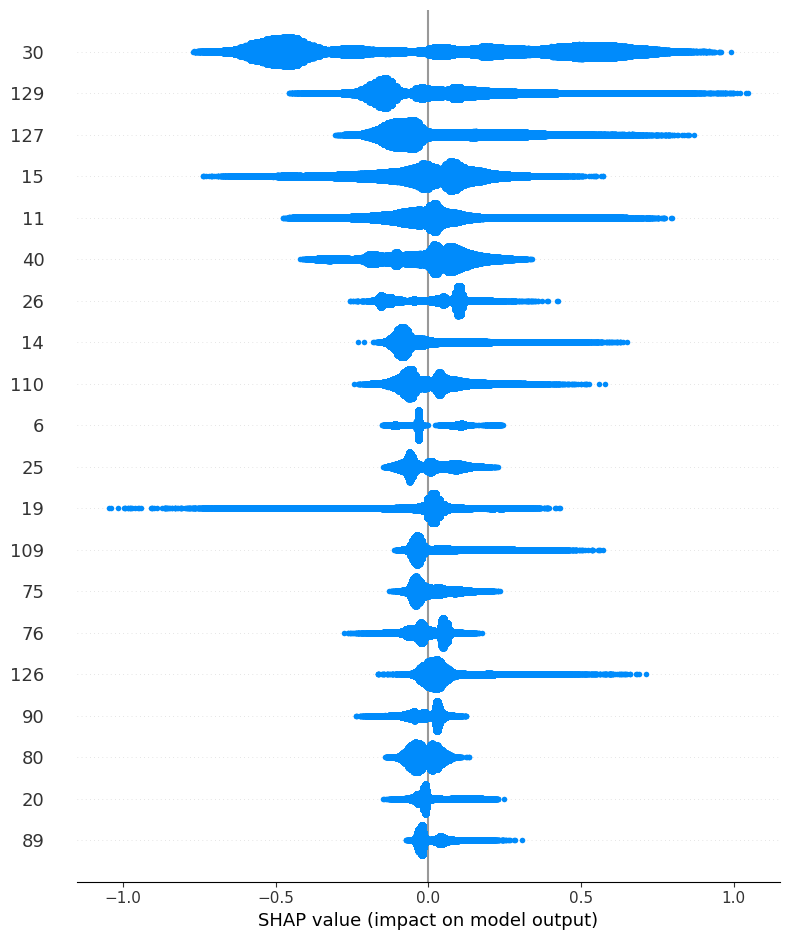

In [ ]:
import shap
shap_values_no_bias = shap_df.drop(columns=["bias", "Unnamed: 0"])
shap_values = shap_values_no_bias.values

# Summary plot
shap.summary_plot(shap_values, feature_names=shap_values_no_bias.columns)

In [ ]:
%pip install shap
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\erika\.pyenv\pyenv-win\versions\3.9.0\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\erika\.pyenv\pyenv-win\versions\3.9.0\python.exe -m pip install --upgrade pip' command.


In [ ]:
# Save the model to a file
model_filename = 'lgb_ranker_model1.txt'
lgb_ranker.booster_.save_model(model_filename)